# Score prospects in real time using Snowplow Signals and machine learning


Welcome to the [Snowplow Signals](https://docs.snowplow.io/docs/signals/) real-time prospect scoring [tutorial](https://docs.snowplow.io/tutorials/signals-ml-prospect-scoring/intro).

This notebook is intended to be used as part of the tutorial. It's hosted in Google Colab so you won't need to configure anything locally.

Check out the tutorial pages to follow along.

## Set up the notebook 

Add your credentials to the Colab notebook secrets.

In [ ]:
import os
try:
    from google.colab import userdata

    # Snowflake credentials to prepare a training dataset on top of atomic events table
    ENV_SF_ACNT = userdata.get('SF_ACNT')   # Account
    ENV_SF_USR = userdata.get('SF_USR')     # User
    ENV_SF_PWD = userdata.get('SF_PWD')     # Password
    ENV_SF_WH = userdata.get('SF_WH')       # Warehouse

    # Snowplow Signals credentials
    ENV_SP_API_URL = userdata.get('SP_API_URL')       # Signals API URL
    ENV_SP_API_KEY = userdata.get('SP_API_KEY')       # Signals API key
    ENV_SP_API_KEY_ID = userdata.get('SP_API_KEY_ID') # Signals API key ID
    ENV_SP_ORG_ID = userdata.get('SP_ORG_ID')         # Snowplow org ID

    # Snowflake Snowplow atomic table
    ENV_ATOMIC_TABLE = userdata.get('ATOMIC_TABLE')

    # ngrok token to be able to expose the notebook behind HTTPS for querying the API
    ENV_NGROK_TOKEN = userdata.get('NGROK_TOKEN')
except ImportError:
    # Snowflake credentials to prepare a training dataset on top of atomic events table
    ENV_SF_ACNT = os.environ.get('SF_ACNT')
    ENV_SF_USR = os.environ.get('SF_USR')
    ENV_SF_PWD = os.environ.get('SF_PWD')
    ENV_SF_WH = os.environ.get('SF_WH')

    # Snowplow Signals credentials
    ENV_SP_API_URL = os.environ.get('SP_API_URL')
    ENV_SP_API_KEY = os.environ.get('SP_API_KEY')
    ENV_SP_API_KEY_ID = os.environ.get('SP_API_KEY_ID')
    ENV_SP_ORG_ID = os.environ.get('SP_ORG_ID')

    # Snowflake Snowplow atomic table
    ENV_ATOMIC_TABLE = os.environ.get('ATOMIC_TABLE')

    # ngrok token to be able to expose the notebook behind HTTPS for querying the API
    ENV_NGROK_TOKEN = os.environ.get('NGROK_TOKEN')

## Set up Signals

### Install the Signals Python SDK

In [ ]:
%pip install snowplow-signals

### Define reusable variables

In [ ]:
from snowplow_signals import Event
from datetime import timedelta

# Standard Snowplow events
sp_page_view = Event(
    vendor="com.snowplowanalytics.snowplow",
    name="page_view",
    version="1-0-0"
)
sp_page_ping = Event(
    vendor="com.snowplowanalytics.snowplow",
    name="page_ping",
    version="1-0-0"
)
sp_submit_form = Event(
    vendor="com.snowplowanalytics.snowplow",
    name="submit_form",
    version="1-0-0"
)
sp_focus_form = Event(
    vendor="com.snowplowanalytics.snowplow",
    name="focus_form",
    version="1-0-0"
)
sp_change_form = Event(
    vendor="com.snowplowanalytics.snowplow",
    name="change_form",
    version="1-0-0"
)
sp_media_events = Event(
    # This will match any event for this vendor
    # because no event name or version are defined
    vendor="com.snowplowanalytics.snowplow.media"
)

l7d=timedelta(days=7)
l30d=timedelta(days=30)

### Define attributes 

In [ ]:
from snowplow_signals import Attribute, Criteria, Criterion

# Latest page_view behavior
latest_app_id = Attribute(
    name="latest_app_id",
    type="string",
    events=[sp_page_view],
    aggregation="last",
    property="app_id"
)

latest_device_class = Attribute(
    name="latest_device_class",
    type="string",
    events=[sp_page_view],
    aggregation="last",
    property="contexts_nl_basjes_yauaa_context_1[0].deviceClass"
)

# Behavior over the last 7 days
num_sessions_l7d = Attribute(
    name="num_sessions_l7d",
    type="string_list",
    events=[sp_page_view],
    period=l7d,
    aggregation="unique_list",
    property="domain_sessionid"
)

num_apps_l7d = Attribute(
    name="num_apps_l7d",
    type="string_list",
    events=[sp_page_view],
    period=l7d,
    aggregation="unique_list",
    property="app_id"
)

num_page_views_l7d = Attribute(
    name="num_page_views_l7d",
    type="int32",
    events=[sp_page_view],
    period=l7d,
    aggregation="counter"
)

num_page_pings_l7d = Attribute(
    name="num_page_pings_l7d",
    type="int32",
    events=[sp_page_ping],
    period=l7d,
    aggregation="counter"
)

num_pricing_views_l7d = Attribute(
    name="num_pricing_views_l7d",
    type="int32",
    events=[sp_page_view],
    period=l7d,
    aggregation="counter",
    criteria=Criteria(
        all=[
            Criterion(
                property="page_url",
                operator="like",
                value="%pricing%"
            )
        ]
    )
)

num_conversions_l7d = Attribute(
    name="num_conversions_l7d",
    type="int32",
    events=[sp_submit_form],
    period=l7d,
    aggregation="counter"
)

num_form_engagements_l7d = Attribute(
    name="num_form_engagements_l7d",
    type="int32",
    events=[sp_focus_form, sp_change_form],
    period=l7d,
    aggregation="counter"
)

# Behavior over the last 30 days
num_sessions_l30d = Attribute(
    name="num_sessions_l30d",
    type="string_list",
    events=[sp_page_view],
    period=l30d,
    aggregation="unique_list",
    property="domain_sessionid"
)

num_apps_l30d = Attribute(
    name="num_apps_l30d",
    type="string_list",
    events=[sp_page_view],
    period=l30d,
    aggregation="unique_list",
    property="app_id"
)

num_page_views_l30d = Attribute(
    name="num_page_views_l30d",
    type="int32",
    events=[sp_page_view],
    period=l30d,
    aggregation="counter"
)

num_page_pings_l30d = Attribute(
    name="num_page_pings_l30d",
    type="int32",
    events=[sp_page_ping],
    period=l30d,
    aggregation="counter"
)

num_pricing_views_l30d = Attribute(
    name="num_pricing_views_l30d",
    type="int32",
    events=[sp_page_view],
    period=l30d,
    aggregation="counter",
    criteria=Criteria(
        all=[
            Criterion(
                property="page_url",
                operator="like",
                value="%pricing%"
            )
        ]
    )
)

num_conversions_l30d = Attribute(
    name="num_conversions_l30d",
    type="int32",
    events=[sp_submit_form],
    period=l30d,
    aggregation="counter"
)

num_media_events_l30d = Attribute(
    name="num_media_events_l30d",
    type="int32",
    events=[sp_media_events],
    period=l30d,
    aggregation="counter"
)

first_refr_medium_l30d = Attribute(
    name="first_refr_medium_l30d",
    type="string",
    events=[sp_page_view],
    period=l30d,
    aggregation="first",
    property="refr_medium"
)

first_mkt_medium_l30d = Attribute(
    name="first_mkt_medium_l30d",
    type="string",
    events=[sp_page_view],
    period=l30d,
    aggregation="first",
    property="mkt_medium"
)

num_engaged_campaigns_l30d = Attribute(
    name="num_engaged_campaigns_l30d",
    type="string_list",
    events=[sp_page_view],
    period=l30d,
    aggregation="unique_list",
    property="mkt_campaign"
)

### Define a view

Note: if you have applied this configuration to Signals already, and have come back to edit the definitions before reapplying, you may need to increase the view version.

In [ ]:
from snowplow_signals import View, domain_userid

user_attributes_view = View(
    name="prospect_scoring",
    version=1,
    entity=domain_userid,
    attributes=[
        latest_app_id,
        latest_device_class,
        num_sessions_l7d,
        num_apps_l7d,
        num_page_views_l7d,
        num_page_pings_l7d,
        num_pricing_views_l7d,
        num_conversions_l7d,
        num_form_engagements_l7d,
        num_sessions_l30d,
        num_apps_l30d,
        num_page_views_l30d,
        num_page_pings_l30d,
        num_pricing_views_l30d,
        num_conversions_l30d,
        num_media_events_l30d,
        first_refr_medium_l30d,
        first_mkt_medium_l30d,
        num_engaged_campaigns_l30d,
    ],
)

### Test the view

In [ ]:
sp_signals_test = sp_signals.test(
    view=user_attributes_view,
    app_ids=["website"]
)

sp_signals_test

### Deploy configuration to Signals

Running this cell will connect to your Signals instance. Signals will start calculating attributes to populate your Profiles Store.

In [ ]:
from snowplow_signals import Signals

sp_signals = Signals(
    api_url=ENV_SP_API_URL,
    api_key=ENV_SP_API_KEY,
    api_key_id=ENV_SP_API_KEY_ID,
    org_id=ENV_SP_ORG_ID
)

applied = sp_signals.apply([user_attributes_view])

# This should print "1 objects applied"
print(f"{len(applied)} objects applied")

## Train ML prospect scoring model

### Install the dependencies

In [4]:
%pip install snowflake-connector-python snowflake-sqlalchemy

### Prepare the SQL query

In [ ]:
query = f"""
with

-- Change to your events table
events_table as (
    select * from {ENV_ATOMIC_TABLE}
    where derived_tstamp >= dateadd('day', -30-30, current_date)
),

-- Filter training dataset
eligible_duids as (
    -- let's train on users who first appeared between 60-30 days ago
    select
        domain_userid,
        min(derived_tstamp) as first_seen
    from events_table
    where domain_userid is not null
        and app_id in ('website', 'hs-landing')
    group by 1
    having first_seen between dateadd('day', -30-30, current_date) and dateadd('day', -30, current_date)
),
events as (
    select *
    from events_table
    -- where ...filter the events/app_ids that you need, exclude testing/bot traffic, etc.
    where domain_userid in (select domain_userid from eligible_duids)
        and domain_sessionid is not null
        and event_name not in ('application_error', 'web_vitals', 'link_click')
),

-- Prepare the target column
targets_as_of_event as (
    -- Target: will this person 'submit_form' in the next 1 hour?
    select
        -- identifiers
        er.event_id,
        -- target
        count_if(ef.event_name = 'submit_form') > 0 as target_had_submit_form_next1h,
    from events er
    left join events ef on er.domain_userid = ef.domain_userid
        and er.derived_tstamp < ef.derived_tstamp -- only future events
        and datediff('second', er.derived_tstamp, ef.derived_tstamp) <= 60 * 60 -- only the next 1h of events
    group by all
),

-- Prepare training features
agg_as_of_event as (
    select
        -- identifiers
        er.event_id,
        -- event features
        nvl(er.app_id, '') as latest_app_id,
        dayofweekiso(er.derived_tstamp) as day_of_week,
        nvl(er.contexts_nl_basjes_yauaa_context_1[0]:deviceClass::string, '') as latest_device_class,

        -- behaviour over the last 7d
        count(distinct iff(datediff('second', eh.derived_tstamp, er.derived_tstamp) <= 60 * 60 * 24 * 7, eh.domain_sessionid, null)) as num_sessions_l7d,
        count(distinct iff(datediff('second', eh.derived_tstamp, er.derived_tstamp) <= 60 * 60 * 24 * 7, eh.app_id, null)) as num_apps_l7d,
        nvl(count_if(iff(datediff('second', eh.derived_tstamp, er.derived_tstamp) <= 60 * 60 * 24 * 7, eh.event_name = 'page_view', null)), 0) as num_page_views_l7d,
        nvl(count_if(iff(datediff('second', eh.derived_tstamp, er.derived_tstamp) <= 60 * 60 * 24 * 7, eh.event_name = 'page_ping', null)), 0) as num_page_pings_l7d,
        nvl(count_if(iff(datediff('second', eh.derived_tstamp, er.derived_tstamp) <= 60 * 60 * 24 * 7, eh.event_name = 'page_view' and eh.page_url like '%pricing%', null)), 0) as num_pricing_views_l7d,
        nvl(count_if(iff(datediff('second', eh.derived_tstamp, er.derived_tstamp) <= 60 * 60 * 24 * 7, eh.event_name = 'submit_form', null)), 0) > 0 as had_conversions_l7d,
        nvl(count_if(iff(datediff('second', eh.derived_tstamp, er.derived_tstamp) <= 60 * 60 * 24 * 7, eh.event_name in ('focus_form', 'change_form'), null)), 0) > 0 as num_form_engagements_l7d,

        -- behaviour over the last 30d
        count(distinct eh.domain_sessionid) as num_sessions_l30d,
        count(distinct eh.app_id) as num_apps_l30d,
        nvl(count_if(eh.event_name = 'page_view'), 0) as num_page_views_l30d,
        nvl(count_if(eh.event_name = 'page_ping'), 0) as num_page_pings_l30d,
        nvl(count_if(eh.event_name = 'page_view' and eh.page_url like '%pricing%'), 0) as num_pricing_views_l30d,
        nvl(count_if(eh.event_name = 'submit_form'), 0) > 0 as had_conversions_l30d,
        nvl(count_if(eh.contexts_com_snowplowanalytics_snowplow_media_player_2 is not null), 0) as num_media_events_l30d,
        nvl(min_by(eh.refr_medium, eh.derived_tstamp), '') as first_refr_medium_l30d,
        nvl(min_by(eh.mkt_medium, eh.derived_tstamp), '') as first_mkt_medium_l30d,
        count(distinct eh.mkt_campaign) as num_engaged_campaigns_l30d,

        -- ...
    from events er
    left join events eh on er.domain_userid = eh.domain_userid
        and eh.derived_tstamp < er.derived_tstamp
        -- Here we join on the last 30d of history.
        -- To calculate any <30d features (e.g. l7d) use datediff in the features.
        and datediff('second', eh.derived_tstamp, er.derived_tstamp) <= 60 * 60 * 24 * 30
    group by all
),
final_training as (
    select
        e.*,
        t.target_had_submit_form_next1h
    from
    agg_as_of_event e
    inner join targets_as_of_event t on e.event_id = t.event_id
)
select * from final_training
"""

### Prepare historical dataset

The code in this cell will connect to your warehouse, and run the query to generate a historical dataset to train from.

In [ ]:
import snowflake.connector
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
seed = 0

conn = snowflake.connector.connect(
    account=ENV_SF_ACNT,
    user=ENV_SF_USR,
    password=ENV_SF_PWD,
    warehouse=ENV_SF_WH,
)

db_df = pd.read_sql(query, conn)
conn.close()

# Snowflake returns all uppercase by default
# Convert column names to lowercase
db_df.columns = db_df.columns.str.lower()

db_df

### Train the model

In [ ]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, ConfusionMatrixDisplay, roc_curve, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# preprocessing
x_columns = [
    'latest_app_id',
    'day_of_week',
    'latest_device_class',
    'num_sessions_l7d',
    'num_apps_l7d',
    'num_page_views_l7d',
    'num_page_pings_l7d',
    'num_pricing_views_l7d',
    'had_conversions_l7d',
    'num_form_engagements_l7d',
    'num_sessions_l30d',
    'num_apps_l30d',
    'num_page_views_l30d',
    'num_page_pings_l30d',
    'num_pricing_views_l30d',
    'had_conversions_l30d',
    'num_media_events_l30d',
    'first_refr_medium_l30d',
    'first_mkt_medium_l30d',
    'num_engaged_campaigns_l30d',
]
y_column = 'target_had_submit_form_next1h'

categorical_cols = [
    'latest_app_id',
    'day_of_week',
    'latest_device_class',
    'first_refr_medium_l30d',
    'first_mkt_medium_l30d',
]
numerical_cols = [
    'num_sessions_l7d',
    'num_apps_l7d',
    'num_page_views_l7d',
    'num_page_pings_l7d',
    'num_pricing_views_l7d',
    'num_form_engagements_l7d',
    'num_sessions_l30d',
    'num_apps_l30d',
    'num_page_views_l30d',
    'num_page_pings_l30d',
    'num_pricing_views_l30d',
    'num_media_events_l30d',
    'num_engaged_campaigns_l30d',
]

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(eval_metric='logloss', random_state=seed))
])

# Split, Train, and Evaluate
X = db_df[x_columns]
y = db_df[y_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

# Check if y_train contains both positive/negative classes
if len(set(y_train)) < 2:
    raise ValueError("Training labels (y_train) have to contain both 'True/False' classes for classification. Adjust your SQL above to provide both classes in the target column `target_had_submit_form_next1h`.")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Export
joblib.dump(model, "xgb_model.joblib")

['xgb_model.joblib']

### Evaluate model performance

In [9]:
# Quick Model Metric Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_prob))
print("Log Loss:", log_loss(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9528667194070867
F1 Score: 0.8209993674889311
ROC AUC:  0.9725110747287488
Log Loss: 0.1308907732538917

Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.98      0.97     20751
        True       0.85      0.79      0.82      3266

    accuracy                           0.95     24017
   macro avg       0.91      0.89      0.90     24017
weighted avg       0.95      0.95      0.95     24017



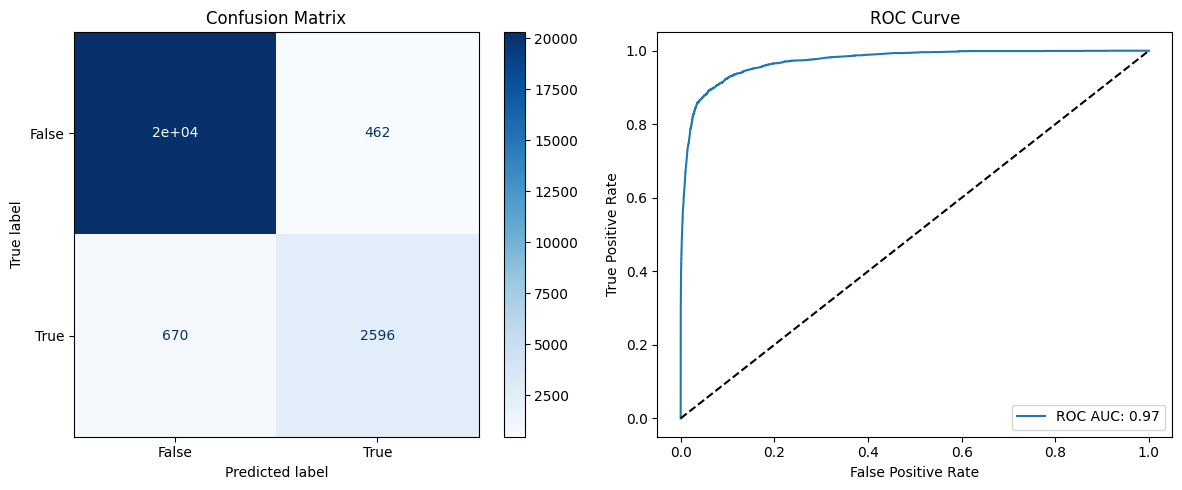

In [10]:
# Visualize Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix")
fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[1].plot(fpr, tpr, label=f'ROC AUC: {roc_auc_score(y_test, y_prob):.2f}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()
axes[1].set_title("ROC Curve")

plt.tight_layout()
plt.show()

In [11]:
# Visualize SHAP Feature Importance
X_train_transformed = model.named_steps['preprocessor'].transform(X_train) #.toarray()
X_test_transformed = model.named_steps['preprocessor'].transform(X_test) #.toarray()

explainer = shap.Explainer(model.named_steps['classifier'], X_train_transformed)
shap_values = explainer(X_test_transformed)
shap_values.feature_names = model.named_steps['preprocessor'].get_feature_names_out()
joblib.dump(explainer, "shap_explainer.joblib")

100%|===================| 23921/24017 [01:32<00:00]       

['shap_explainer.joblib']

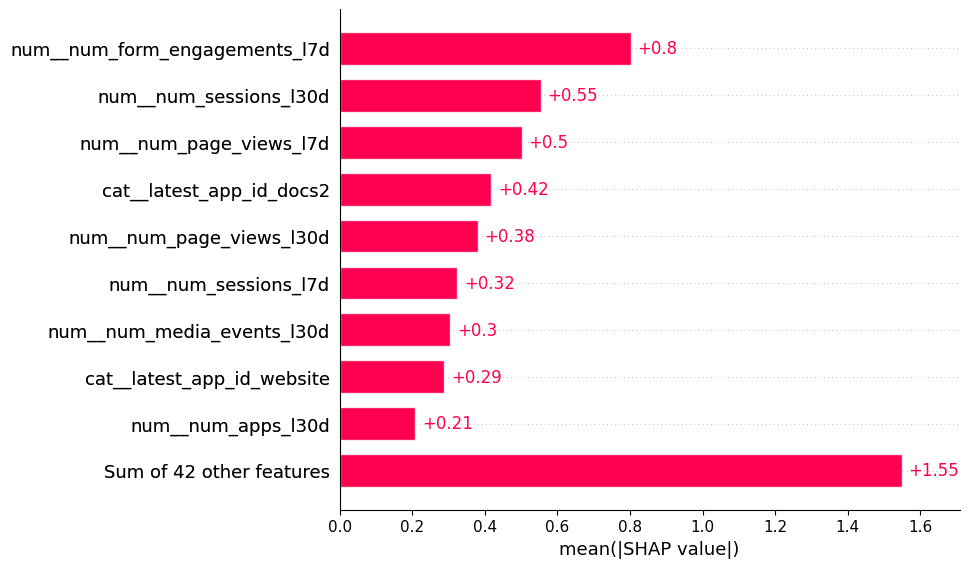

In [12]:
shap.plots.bar(shap_values)

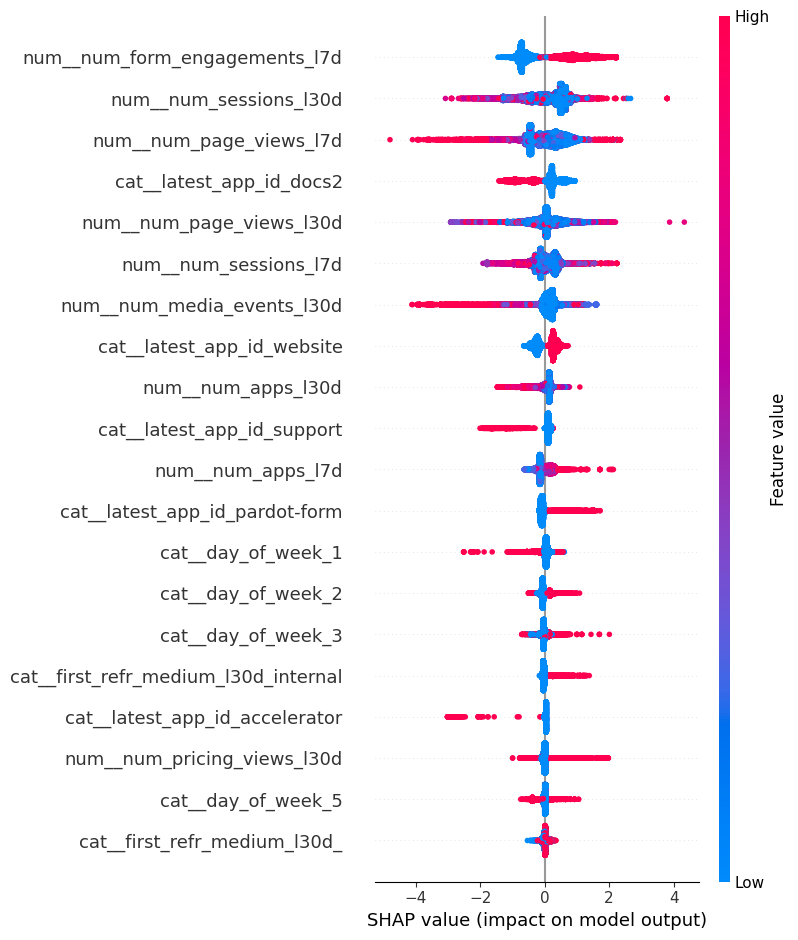

In [13]:
shap.summary_plot(shap_values, X_test_transformed)

## Create an API endpoint

### Install the dependencies

In [20]:
%pip install fastapi nest-asyncio pyngrok uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00


### Define methods and variables

In [ ]:
import joblib
import pandas as pd
from collections import defaultdict
from pydantic import BaseModel
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
import datetime

# Load model
model = joblib.load("xgb_model.joblib")
explainer = joblib.load("shap_explainer.joblib") # shap.Explainer(model.named_steps['classifier'])

# Retrieve attributes from Signals
sp_view = sp_signals.get_view("prospect_scoring")

# Input schema
class InputData(BaseModel):
    domain_userid: str
    # ... add more input columns if needed

# API
app = FastAPI()
app.add_middleware(
    CORSMiddleware,
    allow_origins=['*'],
    allow_credentials=True,
    allow_methods=['*'],
    allow_headers=['*'],
)

# Process the Signals data for individual domain_userids
def get_duid_values(duid: str):
    response = sp_view.get_attributes(
        signals=sp_signals,
        identifier=duid
    )
    df = pd.DataFrame([response])

    # Add your own custom columns and filters
    get_len = lambda x: len(x) if hasattr(x, '__len__') else 0
    df['day_of_week'] = datetime.date.today().isoweekday()
    df[df.filter(like="num_").columns] = df.filter(like="num_").fillna(0)

    # Switch counter columns to booleans
    df['had_conversions_l7d'] = (df['num_conversions_l7d'] > 0).astype(int)
    df['had_conversions_l30d'] = (df['num_conversions_l30d'] > 0).astype(int)
    df = df.drop(columns=['num_conversions_l7d', 'num_conversions_l30d'])

    # Switch unique arrays to amounts
    df['num_sessions_l7d'] = df['num_sessions_l7d'].apply(get_len)
    df['num_apps_l7d'] = df['num_apps_l7d'].apply(get_len)
    df['num_sessions_l30d'] = df['num_sessions_l30d'].apply(get_len)
    df['num_apps_l30d'] = df['num_apps_l30d'].apply(get_len)
    df['num_engaged_campaigns_l30d'] = df['num_engaged_campaigns_l30d'].apply(get_len)

    # Reorder columns to follow the training order
    df = df.reindex(columns=x_columns, fill_value=0)
    return (df, pd.DataFrame([response]))

# Prepare explanations
def get_prediction_explanations(df, top_n=5):
    # Calculate shap values
    df_transformed = model.named_steps['preprocessor'].transform(df) #.toarray()
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    df_transformed_df = pd.DataFrame(df_transformed, columns=feature_names)
    shap_values = explainer(df_transformed_df)
    feature_contributions = dict(zip(
        feature_names,
        shap_values.values[0]
    ))
    # Group feature names: cat__feat_one_value1 -> feat_one
    grouped = defaultdict(float)
    for feat, val in feature_contributions.items():
        base = feat[5:].rsplit('_', 1)[0] if feat.startswith('cat__') else feat.split('__', 1)[1]
        grouped[base] += val
    sorted_grouped = dict(sorted(grouped.items(), key=lambda x: abs(x[1]), reverse=True))
    top_items = dict(list(sorted_grouped.items())[:top_n])
    sum_of_others = sum(sorted_grouped.values()) - sum(top_items.values())
    top_items["__sum_of_others"] = sum_of_others
    top_items = {k: float(v) for k, v in top_items.items()}
    return top_items

# Score the data against the model
def get_predictions(df, explanations=None):
    prediction = float(model.predict_proba(df)[:, 1][0])
    if explanations is None:
        return prediction
    top_contributors = get_prediction_explanations(df, explanations)
    return (prediction, top_contributors)


### Create endpoint

In [ ]:
@app.post("/predict")
def predict(data: InputData):
    input_dict = data.model_dump()

    # Get Signals data and prepare dataframe for scoring
    df, signals_response = get_duid_values(input_dict['domain_userid'])

    # Score dataframe using the trained model
    prediction, explanations = get_predictions(df, 5)

    # Return the result
    print(f"P: {round(prediction, 4)} - {input_dict}")
    return {
        "signals": signals_response.to_dict(orient='records')[0],
        "scoring_attributes": df.to_dict(orient='records')[0],
        "explanations": explanations,
        "score": prediction
    }

## See scores in the browser

### Set up proxy

In [ ]:
import nest_asyncio
from pyngrok import ngrok, conf
import uvicorn

conf.get_default().auth_token = ENV_NGROK_TOKEN
ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

Public URL: https://a0ab-34-86-172-227.ngrok-free.app


INFO:     Started server process [259]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


P: 0.0159 - {'domain_userid': 'a54217b6-2fb7-447a-b229-0d825a6fc40c'}
INFO:     93.170.117.1:0 - "POST /predict HTTP/1.1" 200 OK
P: 0.0159 - {'domain_userid': '9a947ebb-5107-437c-b6c6-1d6cb6be3cf7'}
INFO:     93.170.117.1:0 - "POST /predict HTTP/1.1" 200 OK
P: 0.0698 - {'domain_userid': '9a947ebb-5107-437c-b6c6-1d6cb6be3cf7'}
INFO:     93.170.117.1:0 - "POST /predict HTTP/1.1" 200 OK


### Test using cURL

Now you can call the API using cURL or via JS from the website.

Verify via cURL:

```bash
curl -X POST "https://<REPLACE_WITH_YOUR_NGROK_URL>/predict" \
-H "Content-Type: application/json" \
-d '{"domain_userid": "aaaabbbb-1111-2222-3333-44445555dddd"}'
```

### See scores in the browser

Verify via JS in the browser console:

```js
// Let's call the API every 10s from the frontend
let base_url = "https://<REPLACE_WITH_YOUR_NGROK_URL>";
let api_url = `${base_url}/predict`;
let tracker_name = "sp";

setInterval(function () {
    snowplowTracker(function () {
        // get domain_userid
        var sp = this[tracker_name];
        var domainUserId = sp.getDomainUserId();
        
        // call the API
        fetch(api_url, {
            method: "POST",
            headers: { "Content-Type": "application/json" },
            body: JSON.stringify({ domain_userid: domainUserId })
        })
        .then(response => response.json())
        .then(result => {
            console.log("Prediction: ", domainUserId, " - ", result.score);

            // act on prediction
            if (result.score >= 0.9) console.log('Prospect is likely to convert!');
        })
        .catch(console.error);
    });
}, 10 * 1000);
```

The API response should look like this.
It will have signals-provided attributes, scoring features, prediction score, top5 prediction explanations.
Use `.score` field to get the prediction score for your decisions.

```json
{
  "signals": {
    "domain_userid": "aaaabbbb-1111-2222-3333-44445555dddd",
    "latest_device_class": "Desktop",
    "num_apps_l7d": [
      "website"
    ],
    "first_mkt_medium_l30d": "search",
    "latest_app_id": "website",
    "num_page_pings_l30d": 1,
    "num_sessions_l7d": [
      "1c6a8924-1690-4f92-a573-ee702c2e7365"
    ],
    "num_pricing_views_l7d": 0,
    "num_engaged_campaigns_l30d": [
      "brand-test"
    ],
    "num_page_views_l7d": 2,
    "num_conversions_l30d": 0,
    "num_page_views_l30d": 2,
    "num_pricing_views_l30d": 0,
    "num_media_events_l30d": 0,
    "num_apps_l30d": [
      "website"
    ],
    "num_sessions_l30d": [
      "1c6a8924-1690-4f92-a573-ee702c2e7365"
    ],
    "num_page_pings_l7d": 1,
    "num_conversions_l7d": 0,
    "first_refr_medium_l30d": "",
    "num_form_engagements_l7d": 0
  },
  "scoring_attributes": {
    "latest_app_id": "website",
    "day_of_week": 2,
    "latest_device_class": "Desktop",
    "num_sessions_l7d": 1,
    "num_apps_l7d": 1,
    "num_page_views_l7d": 2,
    "num_page_pings_l7d": 1,
    "num_pricing_views_l7d": 0,
    "had_conversions_l7d": 0,
    "num_form_engagements_l7d": 0,
    "num_sessions_l30d": 1,
    "num_apps_l30d": 1,
    "num_page_views_l30d": 2,
    "num_page_pings_l30d": 1,
    "num_pricing_views_l30d": 0,
    "had_conversions_l30d": 0,
    "num_media_events_l30d": 0,
    "first_refr_medium_l30d": "",
    "first_mkt_medium_l30d": "search",
    "num_engaged_campaigns_l30d": 0
  },
  "explanations": {
    "num_form_engagements_l7d": -1.3108587265014648,
    "latest_app_id": 0.4391634464263916,
    "num_sessions_l7d": 0.4115472435951233,
    "num_page_views_l7d": 0.3009951114654541,
    "num_page_views_l30d": -0.2526836097240448,
    "__sum_of_others": -0.33708104491233826
  },
  "score": 0.040799494832754135
}
```
